In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import signal
import random
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
from sklearn.preprocessing import StandardScaler

In [ ]:
# ドライブのマウント
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


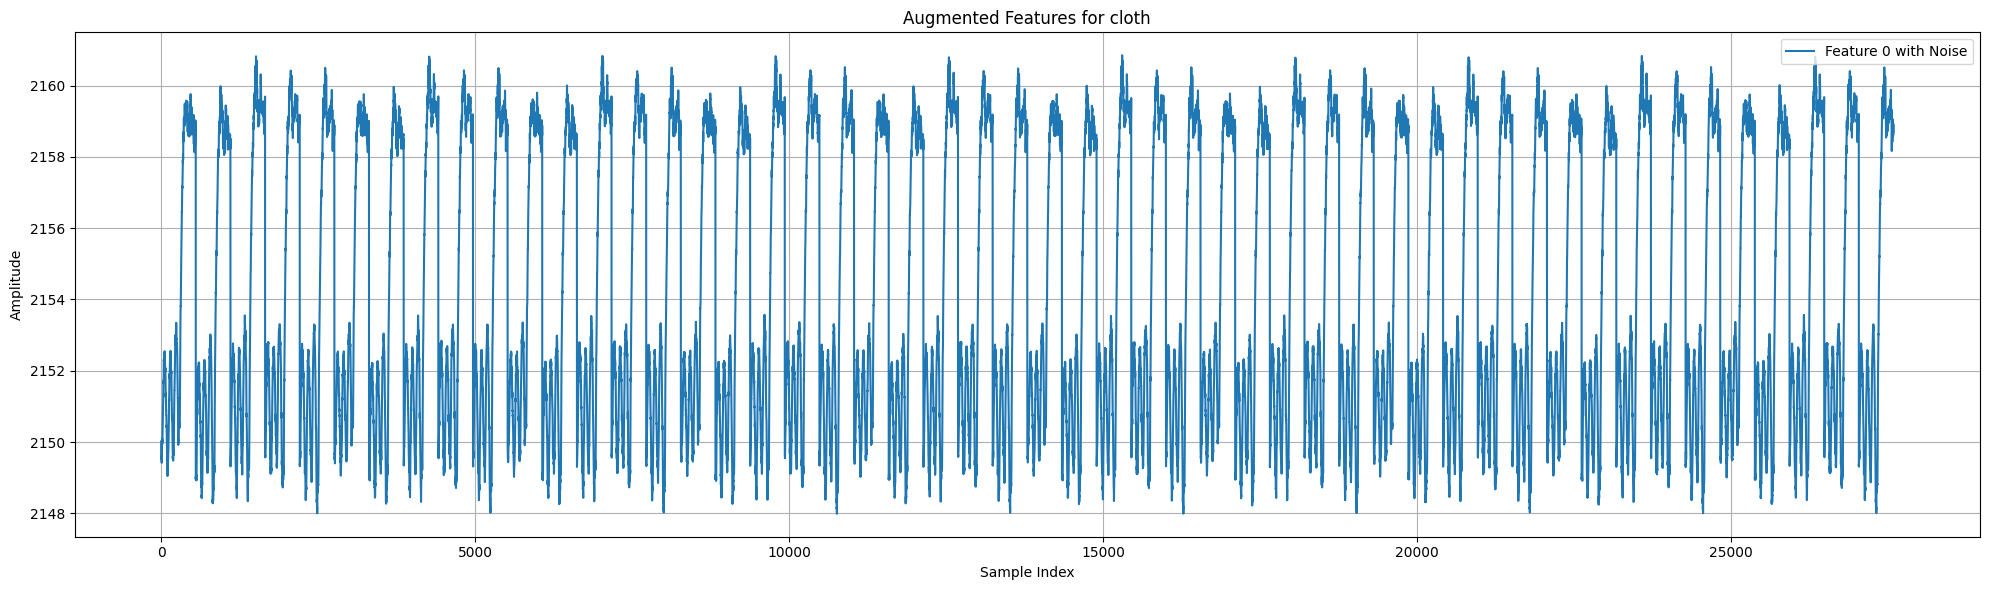

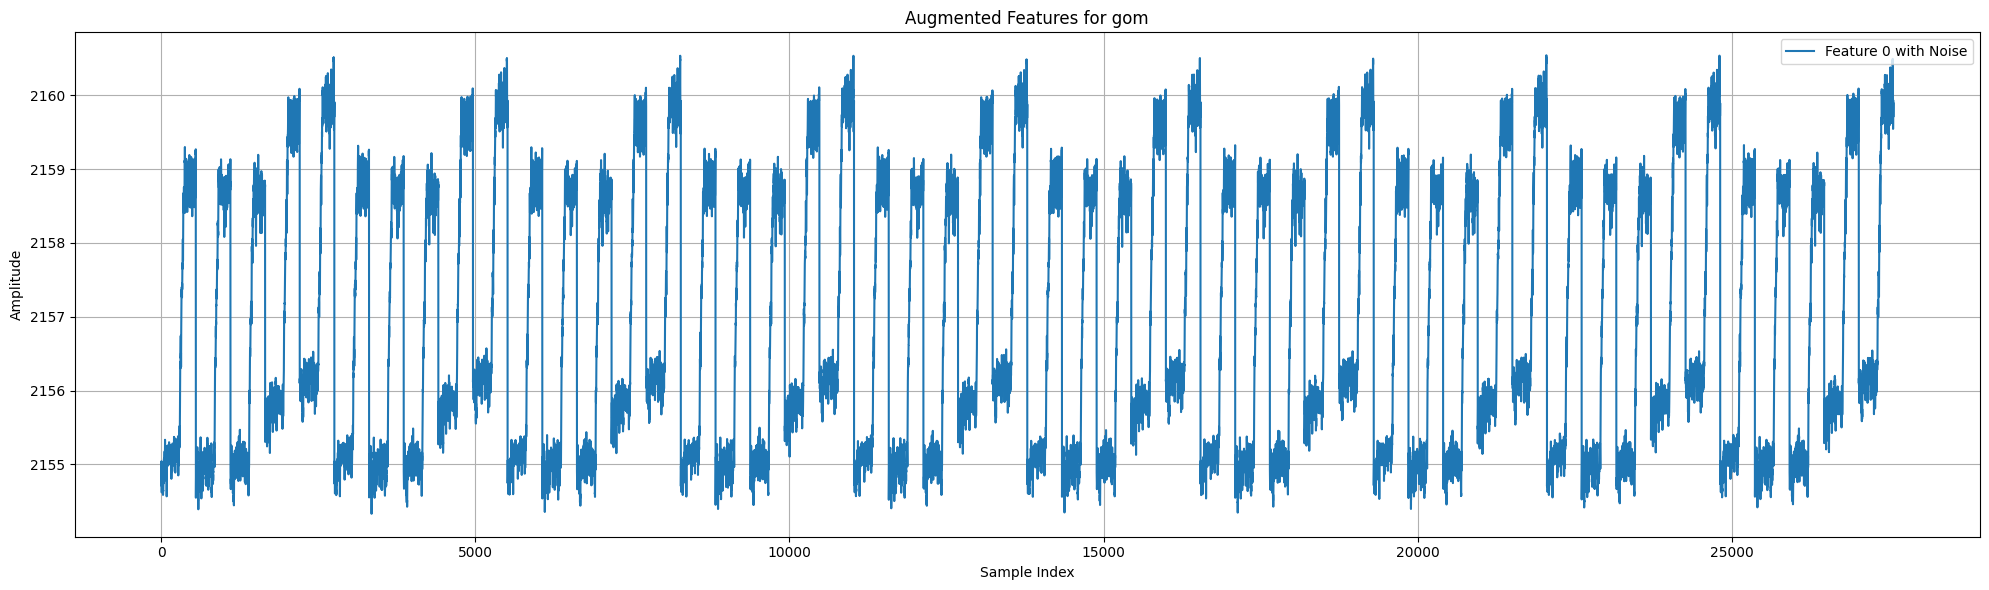

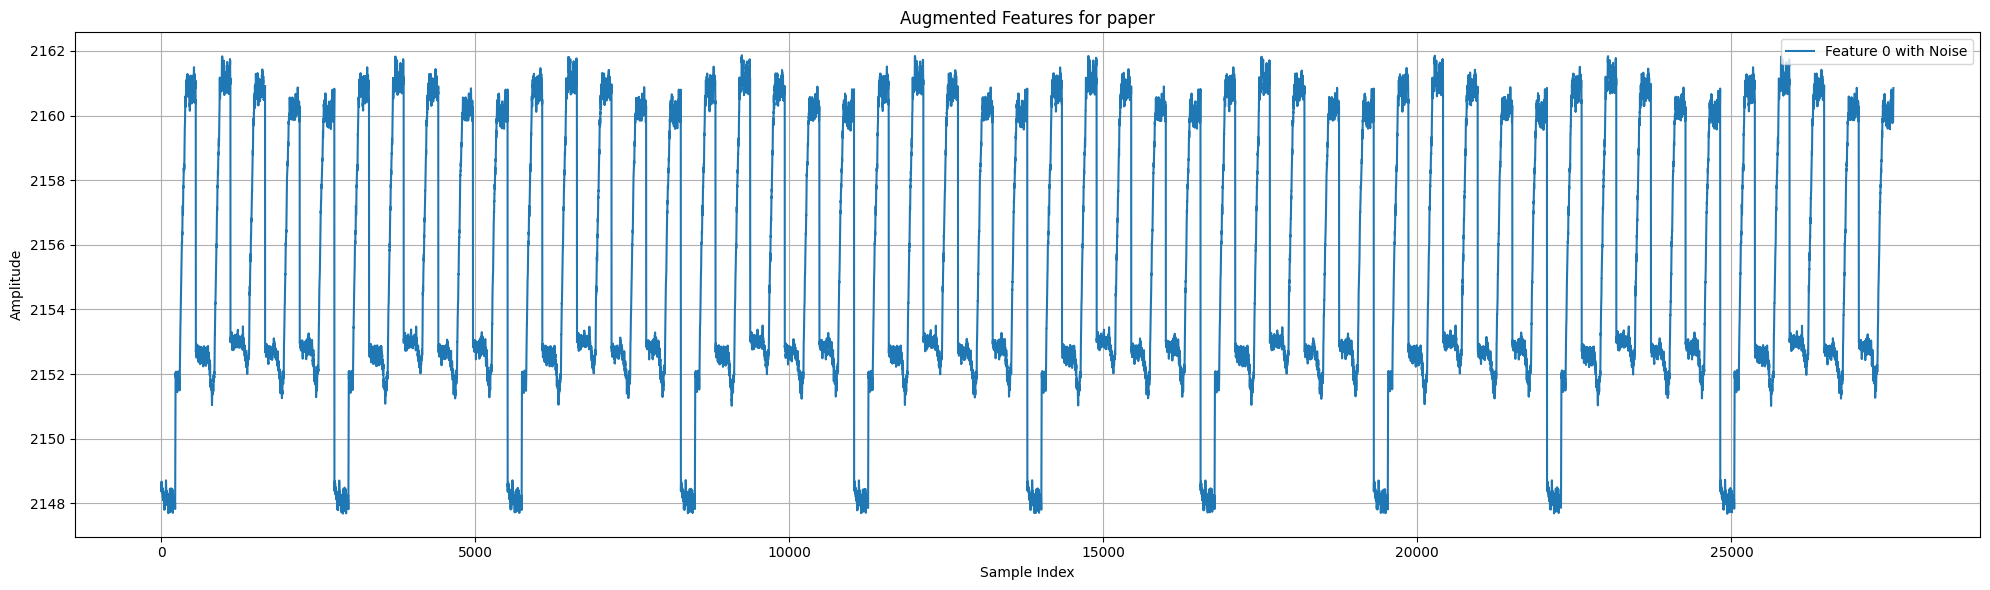

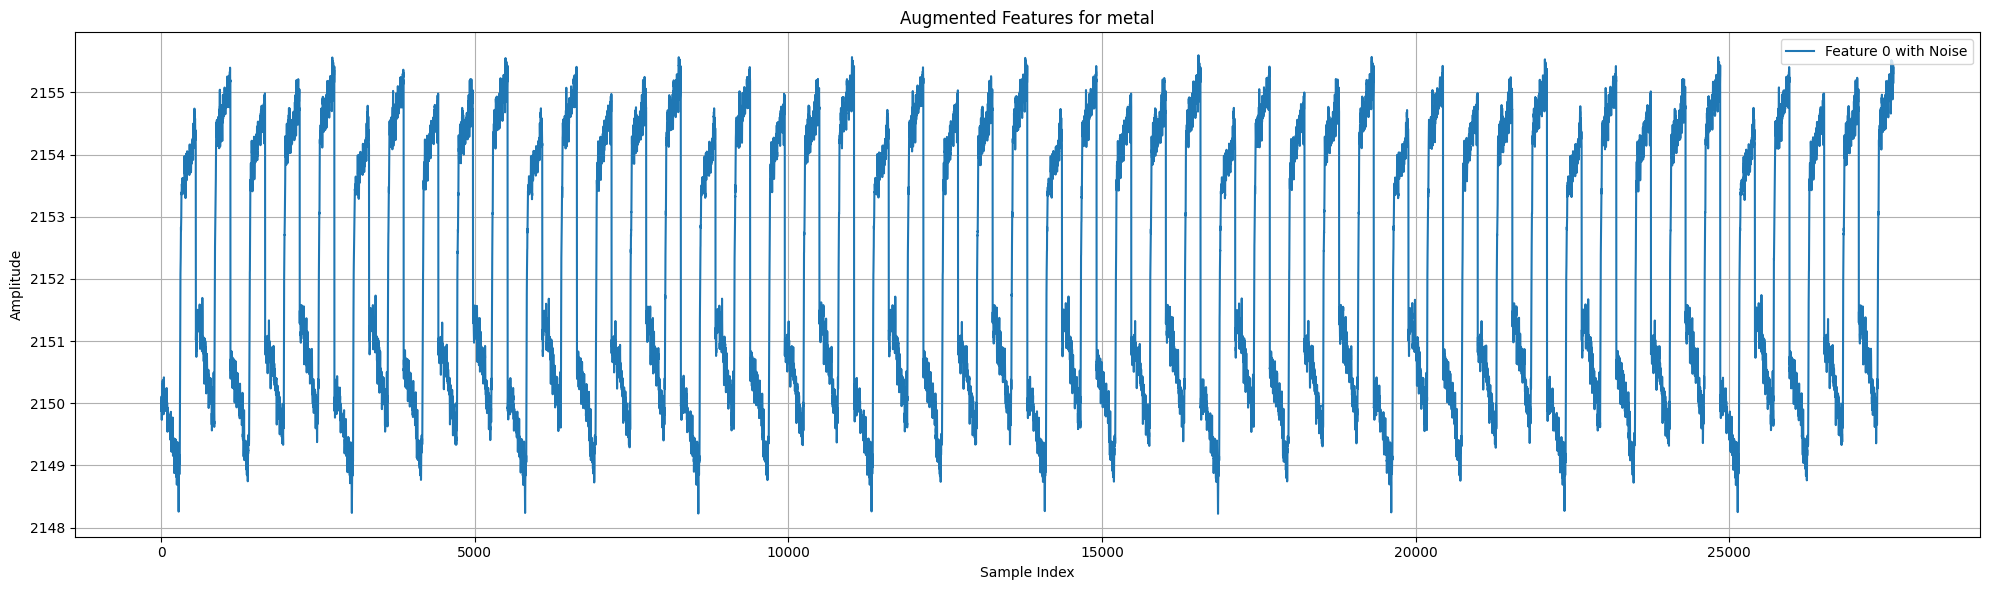

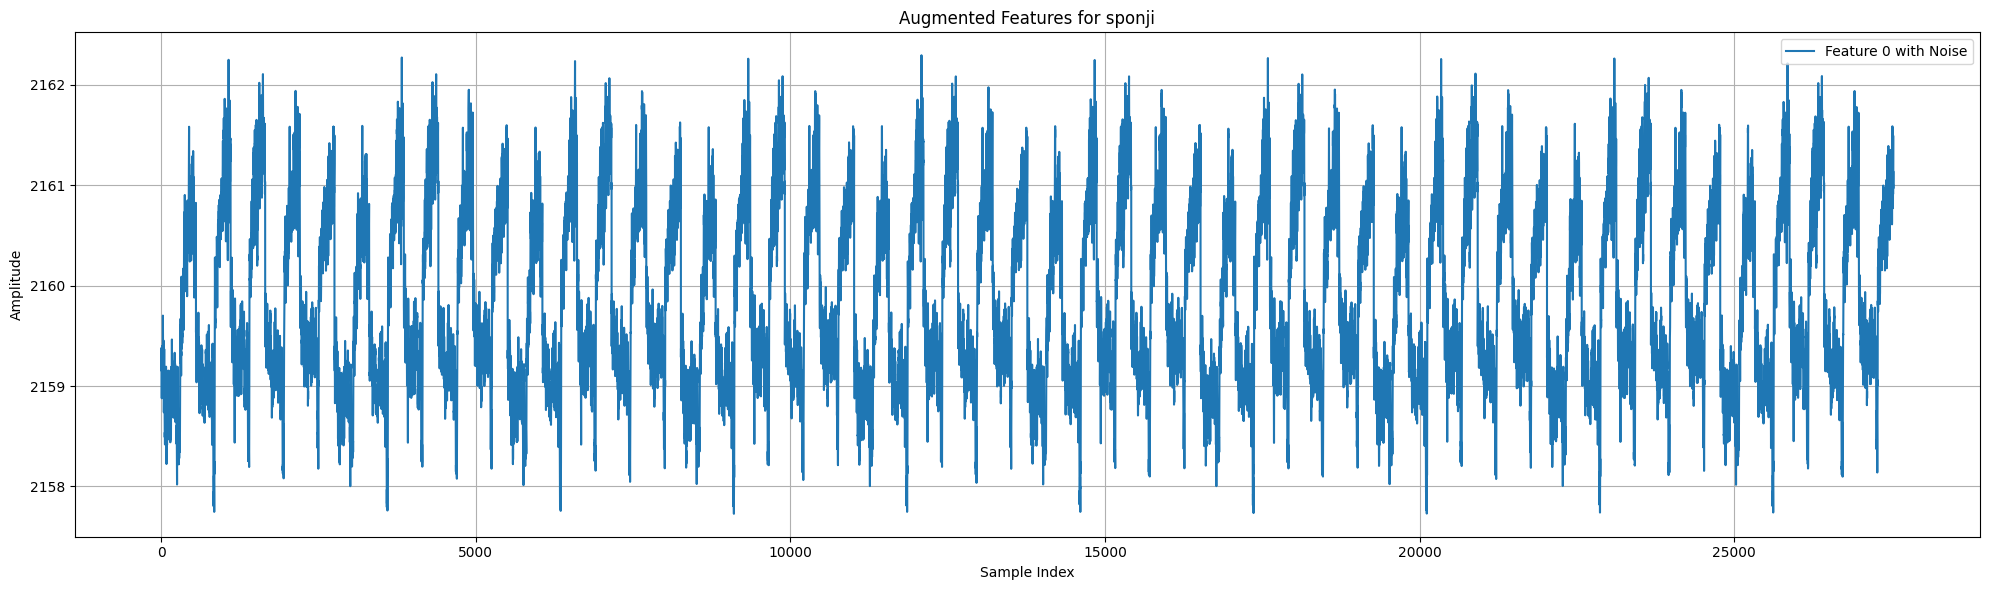

In [60]:
# 実際のフォルダとファイル名を指定
base_path = 'drive/MyDrive/素材データ_斎藤_725_processed_ave500'
materials = ['cloth', 'gom', 'paper', 'metal', 'sponji']  # 素材のフォルダ名

# ノイズを追加する関数
def add_noise(data, noise_level=0.5):
    """データにノイズを付加する"""
    numeric_data = data.select_dtypes(include=np.number)  # 数値列を抽出
    noise = np.random.normal(0, noise_level, numeric_data.shape)  # ノイズを生成
    noisy_data = numeric_data + noise  # 元データにノイズを加える
    noisy_data = pd.DataFrame(noisy_data, columns=numeric_data.columns)  # データフレーム化
    return pd.concat([noisy_data, data.drop(columns=numeric_data.columns)], axis=1)  # クラス列を結合

# 素材ごとのデータを拡張して描画
for material in materials:
    file_path = os.path.join(base_path, f'combined_{material}.csv')  # ファイルパス

    # ファイルを読み取る
    if os.path.exists(file_path):
        try:
            data = pd.read_csv(file_path)  # データを読み込む
            augmented_data = data.copy()  # 元データをコピーしてノイズを追加

            # 元データを10倍に拡張する（ノイズを加えたデータを繰り返す）
            for _ in range(9):  # 9回繰り返して10倍に
                noisy_data = add_noise(data, noise_level=0.02)  # ノイズを追加
                augmented_data = pd.concat([augmented_data, noisy_data], ignore_index=True)

            # 描画
            plt.figure(figsize=(20, 6))
            numeric_columns = augmented_data.select_dtypes(include='number').columns

            # 数値列（ここでは1列）を描画
            for col in numeric_columns[:1]:  # 必要なら [:1] を削除してすべての列を描画
                plt.plot(augmented_data.index, augmented_data[col], label=f'Feature {col} with Noise')

            # グラフの詳細設定
            plt.title(f'Augmented Features for {material}')
            plt.xlabel('Sample Index')
            plt.ylabel('Amplitude')
            plt.legend(loc='upper right')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"エラー内容: {type(e).__name__}, {e}")
    else:
        print(f'{file_path} のデータが見つかりませんでした')


In [ ]:
# # 標準化　平均0　標準偏差1
# # カスタムDatasetクラスの定義
# # クラスラベルのマッピングを定義
# label_mapping = {'cloth': 0, 'gom': 1, 'paper': 2, 'metal': 3, 'sponji': 4}

# # 実際のフォルダとファイル名を指定
# base_path = 'drive/MyDrive/素材データ_斎藤_725_processed'
# materials = ['cloth', 'gom', 'paper', 'metal', 'sponji']  # 素材のフォルダ名

# # 破損ファイルを指定
# corrupted_files = [] # 今回は無し

# class CustomDataset(Dataset):
#     def __init__(self,  materials, base_path, corrupted_files, window_size=2000, overlap=1000):
#         self.materials = materials
#         self.base_path = base_path
#         self.corrupted_files = corrupted_files
#         self.window_size = window_size
#         self.overlap = overlap
#         self.labels = [] # ラベルを格納
#         self.windows_all_data = [] # 切り出し後の全データを格納
#         self.windowed_data = {} # 切り出し後のデータをクラスごとに格納
#         self.scaler = StandardScaler()  # スケーラーを追加
#         self.data = self.load_data()

#     def load_data(self):
#         # 素材ごとにデータを連結
#         # 素材ごとのデータを拡張して描画
#         for material in materials:
#             file_path = os.path.join(base_path, f'combined_{material}.csv')  # ファイルパス

#             # ファイルを読み取る
#             if os.path.exists(file_path):
#                 try:
#                     data = pd.read_csv(file_path)  # データを読み込む
#                     augmented_data = data.copy()  # 元データをコピーしてノイズを追加

#                     # 元データを20倍に拡張する（ノイズを加えたデータを繰り返す）
#                     for _ in range(9):  # 19回繰り返して20倍に
#                         noisy_data = add_noise(data, noise_level=0.02)  # ノイズを追加
#                         augmented_data = pd.concat([augmented_data, noisy_data], ignore_index=True)

#                     # 笠増ししたデータに対する処理
#                     augmented_data = augmented_data.reset_index(drop=True) # Indexの整理
#                     augmented_data = augmented_data.dropna() # nan値処理
#                     augmented_data['class'] = material # クラスラベルを追加

#                     # 特徴量の標準化
#                     numeric_columns = augmented_data.select_dtypes(include='number').columns
#                     augmented_data[numeric_columns] = self.scaler.fit_transform(augmented_data[numeric_columns])

#                     # データ数を確認
#                     print(f"{material} has {len(augmented_data)} rows data.")

#                     ### windowの切り出し
#                     class_windows = []

#                     for i in range(0, len(augmented_data) - self.window_size + 1, self.window_size - self.overlap):
#                         window = augmented_data.iloc[i:i+self.window_size] # windowで切り出し
#                         class_windows.append(window) # class_windowに切り出した波形を追加
#                         self.windows_all_data.append(window) # すべてのwindowデータ数を格納
#                         self.labels.append(material) # ラベルを格納

#                     # クラスごとにデータを格納
#                     self.windowed_data[material] = class_windows

#                     # 描画
#                     plt.figure(figsize=(20, 6))
#                     numeric_columns = augmented_data.select_dtypes(include='number').columns

#                     # 数値列（ここでは1列）を描画
#                     for col in numeric_columns[:1]:  # 必要なら [:1] を削除してすべての列を描画
#                         plt.plot(augmented_data.index, augmented_data[col], label=f'Feature {col} with Noise')

#                     # グラフの詳細設定
#                     plt.title(f'Augmented Features for {material}')
#                     plt.xlabel('Sample Index')
#                     plt.ylabel('Amplitude')
#                     plt.legend(loc='upper right')
#                     plt.grid(True)

#                     plt.tight_layout()
#                     plt.show()

#                 except Exception as e:
#                     print(f"エラー内容: {type(e).__name__}, {e}")
#             else:
#                 print(f'{file_path} のデータが見つかりませんでした')

#     # データセットの長さ
#     def __len__(self):
#         return len(self.windows_all_data)

#     # データセットのアイテムを取得
#     def __getitem__(self, idx):
#         window = self.windows_all_data[idx]
#         label = self.labels[idx]

#         # 数値型のみを選択
#         window_numeric = window.select_dtypes(include=[np.number])  # 数値型のカラムのみを選択
#         # DataFrameからnumpy配列に変換してからTensorに変換
#         window_tensor = torch.tensor(window_numeric.to_numpy(), dtype=torch.float32)
#         # 文字列ラベルを整数に変換
#         label_tensor = torch.tensor(label_mapping[label], dtype=torch.long)

#         return window_tensor, label_tensor

#     # クラスごとにwindowを描画
#     def plot_windows_by_class(self, n_windows=3):
#         # クラスごとにプロットを作成
#         for material, class_windows in self.windowed_data.items():
#           if len(class_windows) == 0:
#             print(f"No windows available for class: {material}")
#             continue

#           plt.figure(figsize=(12, 6))  # 各クラスごとに図のサイズを設定

#           # 各クラスからランダムにn個のウィンドウを選択
#           selected_windows = random.sample(class_windows, min(n_windows, len(class_windows)))

#           for i, window in enumerate(selected_windows):
#               # x軸（時間軸）を作成
#               time = np.arange(len(window))

#               # 全特徴量を描画
#               for j in range(window.shape[1] - 1):  # 最後の列は "class" 列なので除外
#                   plt.plot(time, window.iloc[:, j], label=f'Feature {j+1}' if i == 0 else "")  # 最初のウィンドウのみ凡例表示

#           # クラス名をタイトルに設定
#           plt.title(f'Random {n_windows} Windows for Class: {material}')
#           plt.xlabel('Time (Sample Index)')
#           plt.ylabel('Amplitude')
#           plt.grid(True)  # グリッドを表示
#           plt.legend(loc='upper right')  # ラベルを右上に配置
#           plt.tight_layout()  # レイアウトを調整
#           plt.show()

In [74]:
### 平均値のみの処理
# カスタムDatasetクラスの定義
# クラスラベルのマッピングを定義
label_mapping = {'cloth': 0, 'gom': 1, 'paper': 2, 'metal': 3, 'sponji': 4}

# 実際のフォルダとファイル名を指定
base_path = 'drive/MyDrive/素材データ_斎藤_725_processed_avenone'
materials = ['cloth', 'gom', 'paper', 'metal', 'sponji']  # 素材のフォルダ名

# 破損ファイルを指定
corrupted_files = [] # 今回は無し
# カスタムDatasetクラスの定義
class CustomDataset(Dataset):
    def __init__(self,  materials, base_path, corrupted_files, window_size=2000, overlap=1000):
        self.materials = materials
        self.base_path = base_path
        self.corrupted_files = corrupted_files
        self.window_size = window_size
        self.overlap = overlap
        self.labels = []  # ラベルを格納
        self.windows_all_data = []  # 切り出し後の全データを格納
        self.windowed_data = {}  # 切り出し後のデータをクラスごとに格納
        self.data = self.load_data()

    def load_data(self):
        # 素材ごとにデータを連結
        for material in self.materials:
            file_path = os.path.join(self.base_path, f'combined_{material}.csv')  # ファイルパス

            if os.path.exists(file_path):
                try:
                    data = pd.read_csv(file_path)
                    augmented_data = data.copy()  # 元データをコピーしてノイズを追加

                    for _ in range(0):  # データ拡張
                        noisy_data = add_noise(data, noise_level=0.02)
                        augmented_data = pd.concat([augmented_data, noisy_data], ignore_index=True)

                    augmented_data = augmented_data.reset_index(drop=True)
                    augmented_data = augmented_data.dropna()
                    augmented_data['class'] = material

                    # 平均値を0にする処理
                    numeric_columns = augmented_data.select_dtypes(include='number').columns
                    for col in numeric_columns:
                        augmented_data[col] = augmented_data[col] - augmented_data[col].mean()

                    # データ数を確認
                    print(f"{material} has {len(augmented_data)} rows data.")

                                # 描画
                    plt.figure(figsize=(20, 6))
                    numeric_columns = augmented_data.select_dtypes(include='number').columns

                    # 数値列（ここでは1列）を描画
                    for col in numeric_columns[:1]:  # 必要なら [:1] を削除してすべての列を描画
                        plt.plot(augmented_data.index, augmented_data[col], label=f'Feature {col} with Noise')

                    # グラフの詳細設定
                    plt.title(f'Augmented Features for {material}')
                    plt.xlabel('Sample Index')
                    plt.ylabel('Amplitude')
                    plt.legend(loc='upper right')
                    plt.grid(True)

                    plt.tight_layout()
                    plt.show()

                    # windowの切り出し
                    class_windows = []
                    for i in range(0, len(augmented_data) - self.window_size + 1, self.window_size - self.overlap):
                        window = augmented_data.iloc[i:i + self.window_size]
                        class_windows.append(window)
                        self.windows_all_data.append(window)
                        self.labels.append(material)

                    self.windowed_data[material] = class_windows

                except Exception as e:
                    print(f"エラー内容: {type(e).__name__}, {e}")
            else:
                print(f'{file_path} のデータが見つかりませんでした')

    def __len__(self):
        return len(self.windows_all_data)

    def __getitem__(self, idx):
        window = self.windows_all_data[idx]
        label = self.labels[idx]

        window_numeric = window.select_dtypes(include=[np.number])
        window_tensor = torch.tensor(window_numeric.to_numpy(), dtype=torch.float32)
        label_tensor = torch.tensor(label_mapping[label], dtype=torch.long)

        return window_tensor, label_tensor
    # クラスごとにwindowを描画
    def plot_windows_by_class(self, n_windows=3):
        # クラスごとにプロットを作成
        for material, class_windows in self.windowed_data.items():
          if len(class_windows) == 0:
            print(f"No windows available for class: {material}")
            continue

          plt.figure(figsize=(12, 6))  # 各クラスごとに図のサイズを設定

          # 各クラスからランダムにn個のウィンドウを選択
          selected_windows = random.sample(class_windows, min(n_windows, len(class_windows)))

          for i, window in enumerate(selected_windows):
              # x軸（時間軸）を作成
              time = np.arange(len(window))

              # 全特徴量を描画
              for j in range(window.shape[1] - 1):  # 最後の列は "class" 列なので除外
                  plt.plot(time, window.iloc[:, j], label=f'Feature {j+1}' if i == 0 else "")  # 最初のウィンドウのみ凡例表示

          # クラス名をタイトルに設定
          plt.title(f'Random {n_windows} Windows for Class: {material}')
          plt.xlabel('Time (Sample Index)')
          plt.ylabel('Amplitude')
          plt.grid(True)  # グリッドを表示
          plt.legend(loc='upper right')  # ラベルを右上に配置
          plt.tight_layout()  # レイアウトを調整
          plt.show()

cloth has 2784 rows data.


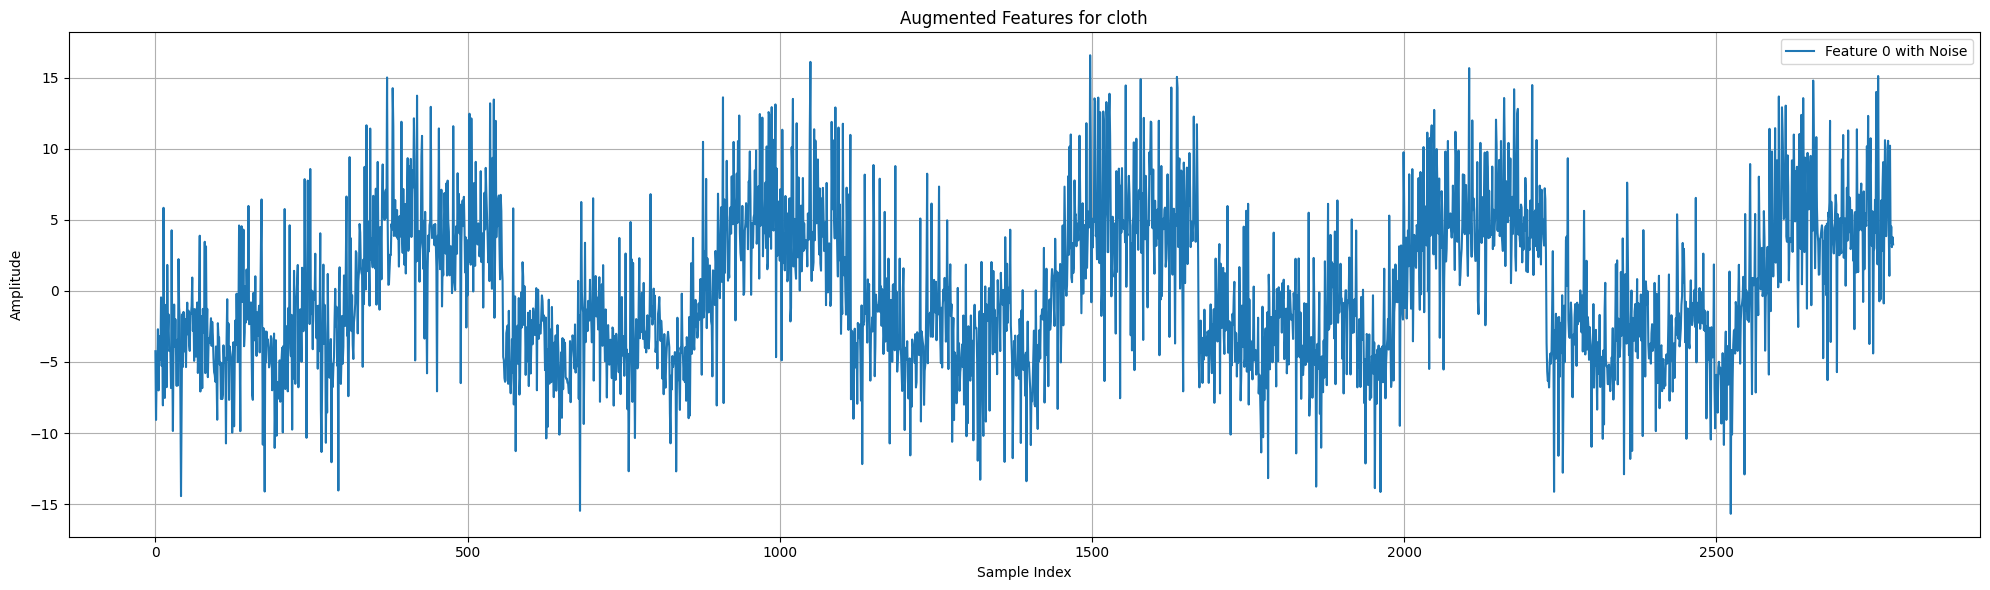

gom has 2782 rows data.


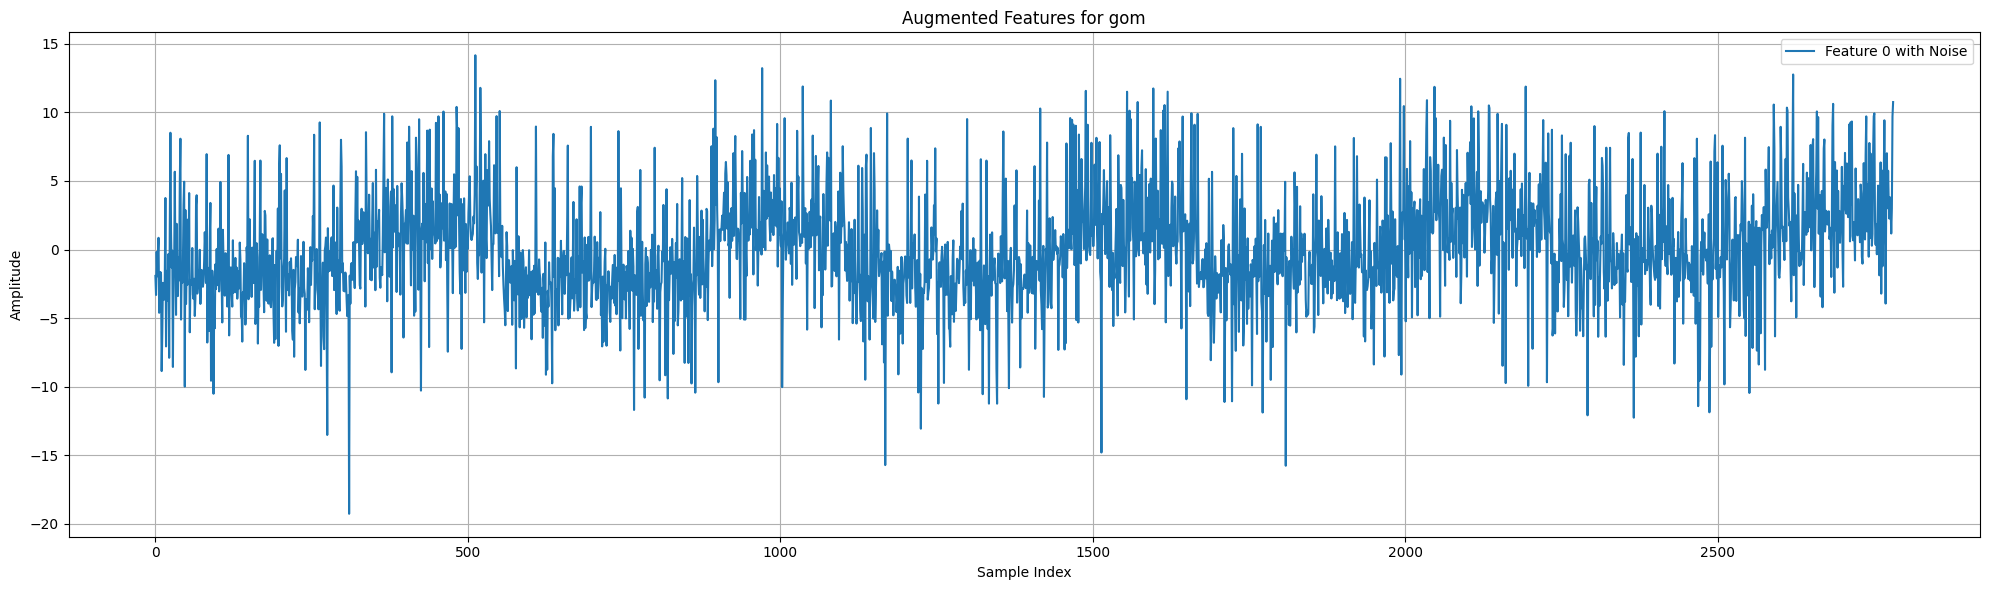

paper has 2783 rows data.


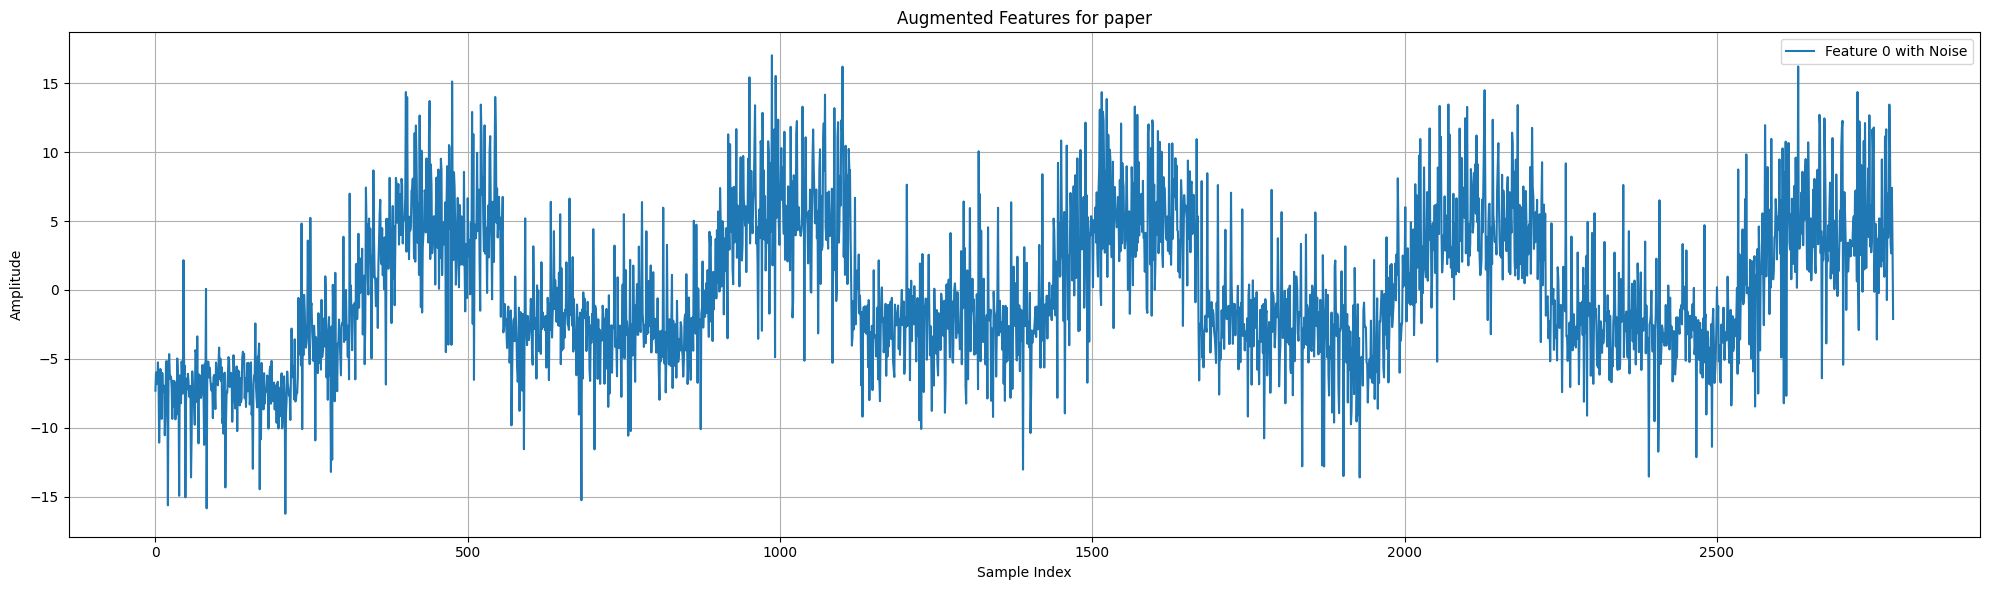

metal has 2787 rows data.


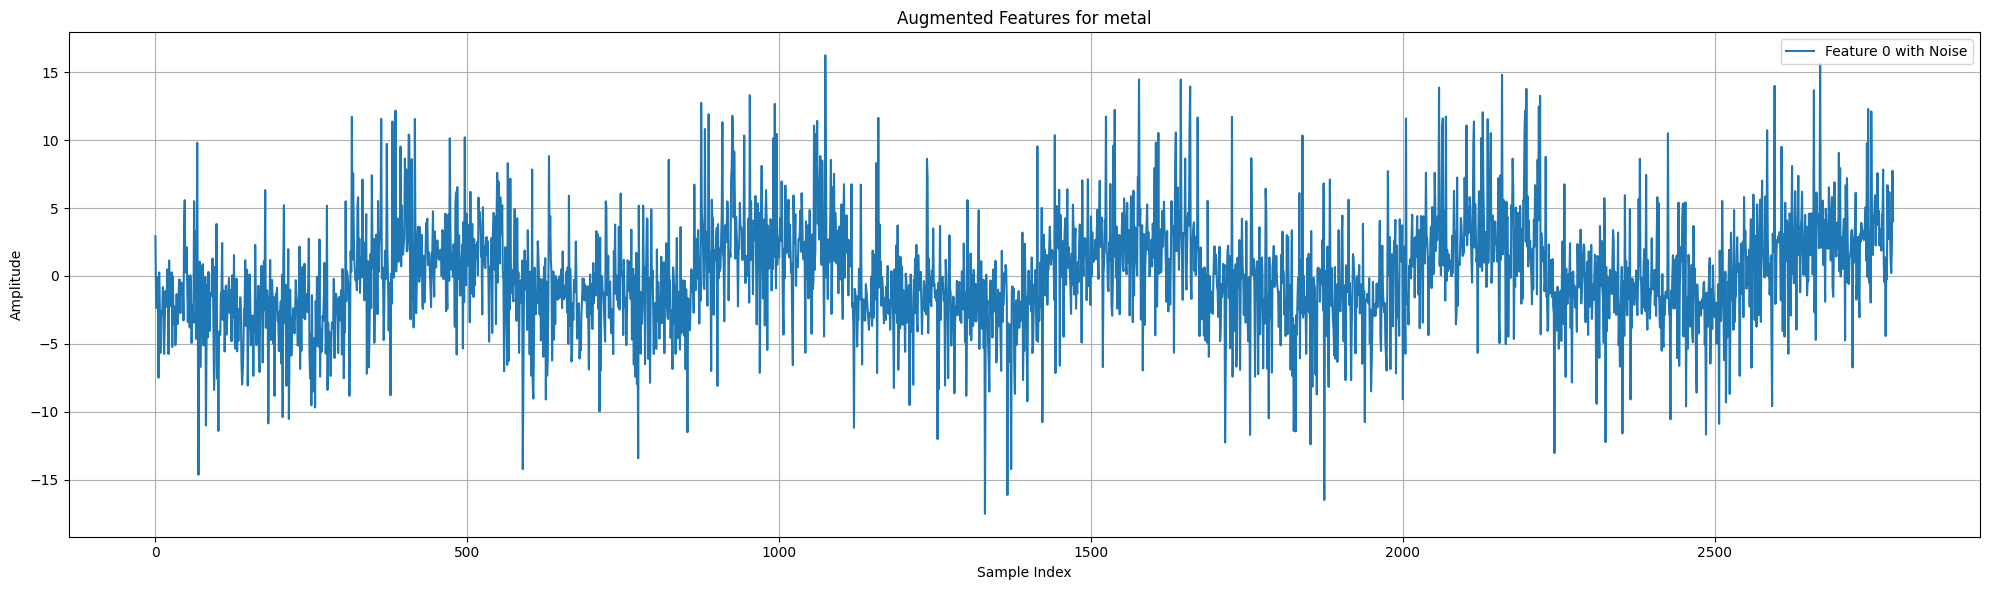

sponji has 2778 rows data.


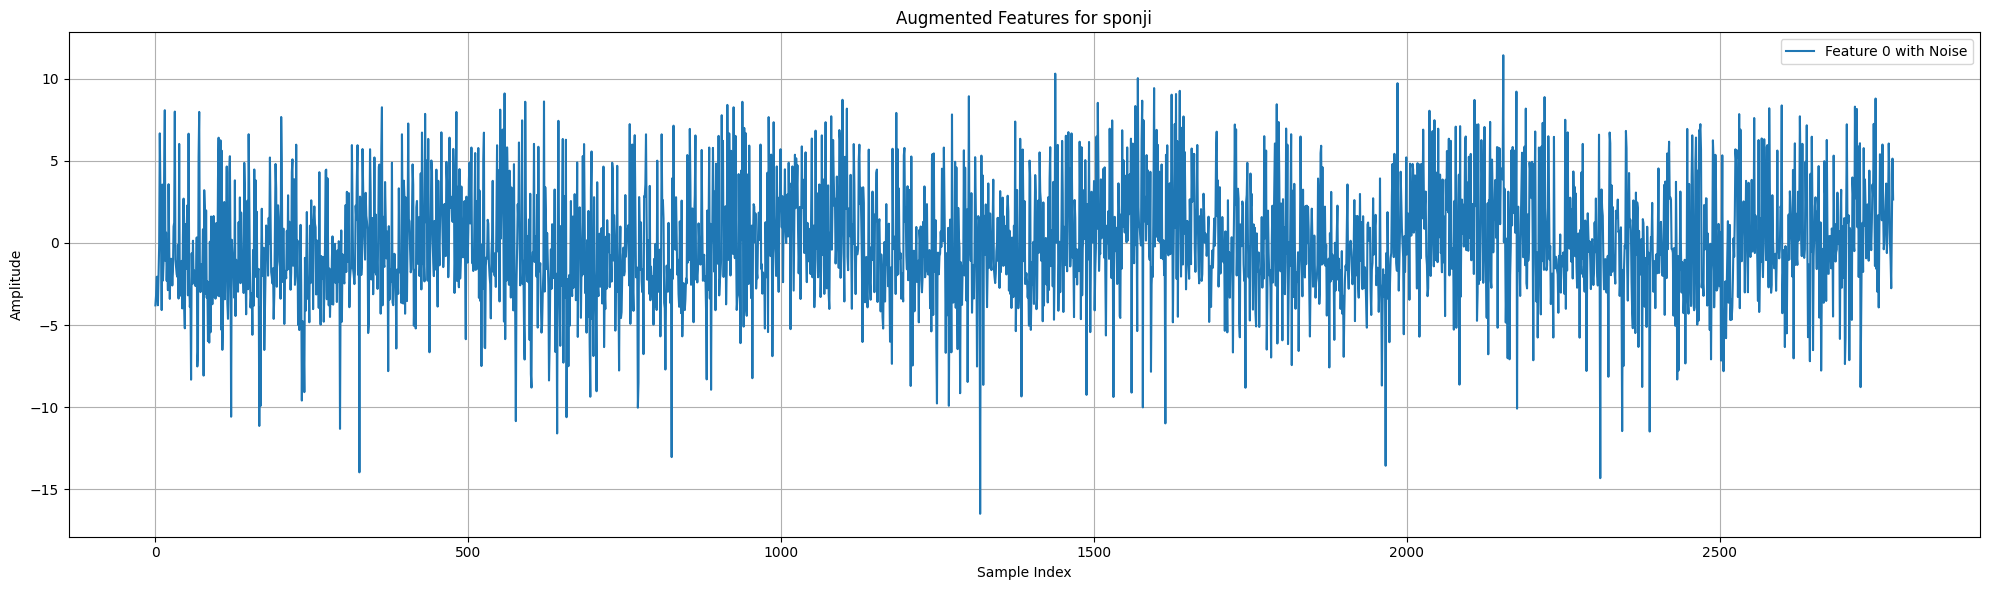

Dataset size: 260


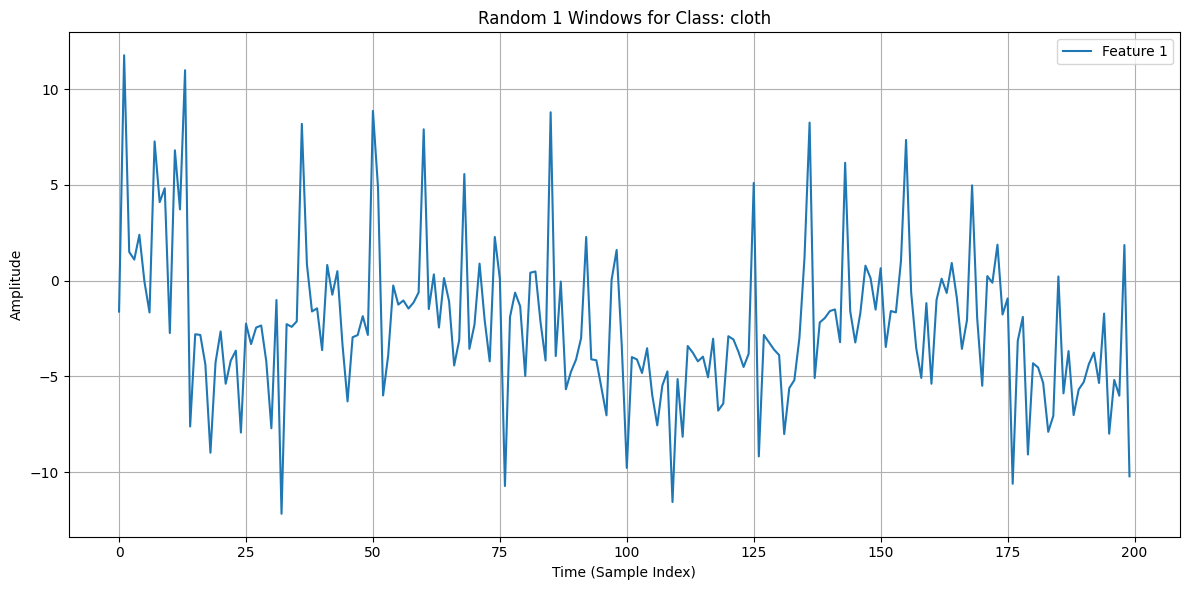

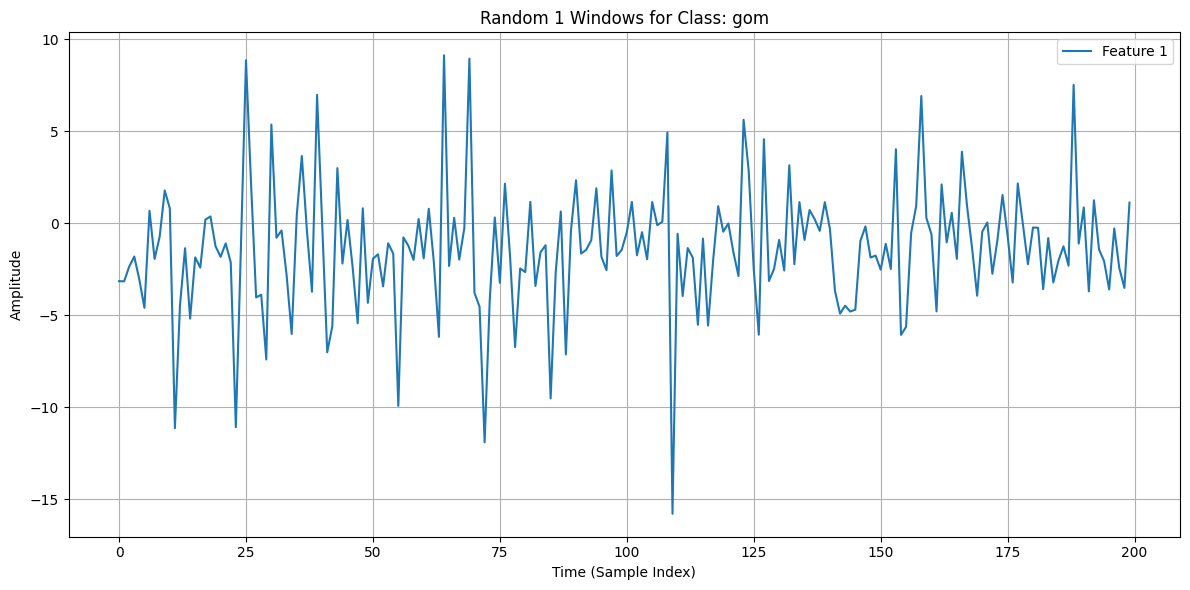

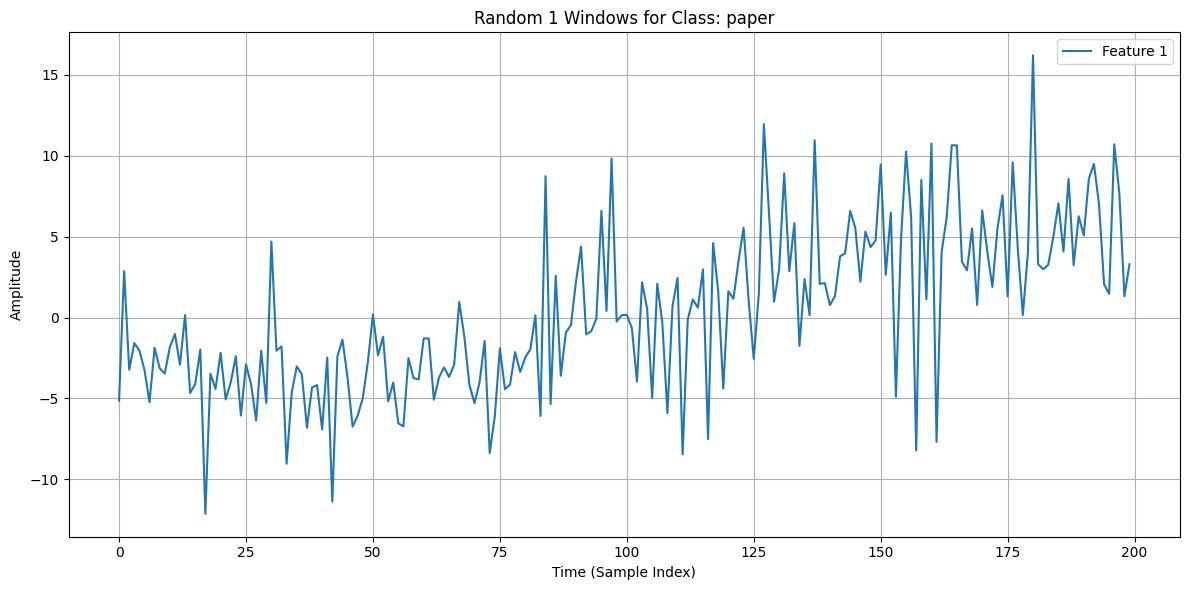

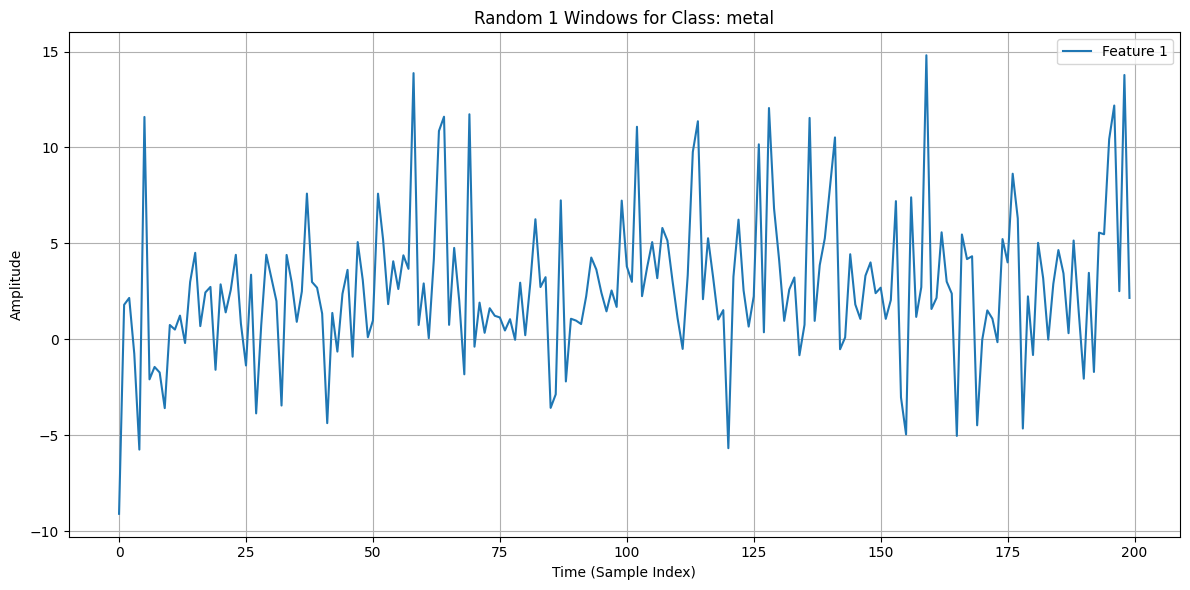

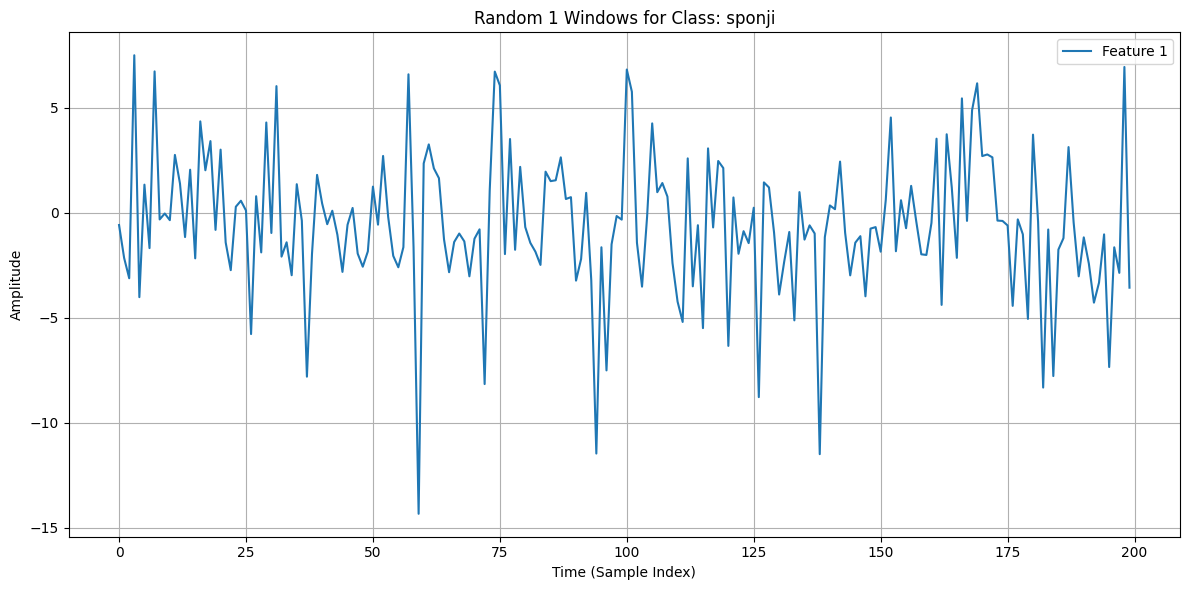

In [76]:
# カスタムデータセットをインスタンス
dataset = CustomDataset(materials, base_path, corrupted_files, window_size=200, overlap=150)
# データセットの長さを確認
print(f"Dataset size: {len(dataset)}")


# 0番目のウィンドウを描画
dataset.plot_windows_by_class(n_windows=1)



In [77]:
# データセットの長さ
dataset_size = len(dataset)
from torch.utils.data import Dataset, DataLoader, random_split
# 訓練データと検証データに分割
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# データ確認（トレーニングデータ）
for batch_data, batch_labels in train_loader:
    print(f"Train Batch data shape: {batch_data.shape}")
    print(f"Train Batch labels shape: {batch_labels.shape}")
    break  # 最初のバッチだけ確認

# データ確認（検証データ）
for batch_data, batch_labels in val_loader:
    print(f"Val Batch data shape: {batch_data.shape}")
    print(f"Val Batch labels shape: {batch_labels.shape}")
    break  # 最初のバッチだけ確認

print(f"full: {len(dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")


Train Batch data shape: torch.Size([32, 200, 1])
Train Batch labels shape: torch.Size([32])
Val Batch data shape: torch.Size([32, 200, 1])
Val Batch labels shape: torch.Size([32])
full: 260 -> train: 208, test: 52


In [78]:
from collections import Counter

# トレーニングデータのラベル確認
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
print(f"Train labels: {train_labels[:10]}")  # 最初の10個を表示
print(f"Train label distribution: {Counter(train_labels)}")  # ラベル分布を確認

# 検証データのラベル確認
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]
print(f"Validation labels: {val_labels[:10]}")  # 最初の10個を表示
print(f"Validation label distribution: {Counter(val_labels)}")  # ラベル分布を確認


Train labels: [tensor(0), tensor(1), tensor(1), tensor(3), tensor(4), tensor(2), tensor(4), tensor(0), tensor(2), tensor(0)]
Train label distribution: Counter({tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(3): 1, tensor(4): 1, tensor(2): 1, tensor(4): 1, tensor(0): 1, tensor(2): 1, tensor(0): 1, tensor(0): 1, tensor(4): 1, tensor(0): 1, tensor(0): 1, tensor(2): 1, tensor(4): 1, tensor(2): 1, tensor(0): 1, tensor(0): 1, tensor(4): 1, tensor(4): 1, tensor(4): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(2): 1, tensor(2): 1, tensor(1): 1, tensor(2): 1, tensor(1): 1, tensor(3): 1, tensor(2): 1, tensor(0): 1, tensor(4): 1, tensor(2): 1, tensor(3): 1, tensor(0): 1, tensor(4): 1, tensor(2): 1, tensor(2): 1, tensor(3): 1, tensor(1): 1, tensor(1): 1, tensor(2): 1, tensor(3): 1, tensor(0): 1, tensor(4): 1, tensor(3): 1, tensor(3): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(2): 1, tensor(2): 1, tensor(0): 1, tensor(1): 1, tensor(3): 1, tensor(2): 1, tensor(0): 1, 

**以下より学習モデル**

In [79]:
# 恒等写像
def identity(x):
    return x # pytorchのテンソルをそのまま処理可能


# 入力層
class Input(nn.Module):
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        super(Input, self).__init__()
        # 一様分布に従う乱数
        torch.manual_seed(seed)
        self.Win = nn.Parameter(torch.empty((N_u, N_x)).uniform_(-input_scale, input_scale))
        self.Win.requires_grad = False  # 勾配更新を不要にする

    def get_weight_matrix(self):
        # 入力行列Winを返す
        return self.Win

In [68]:
class Reservoir(nn.Module):
    def __init__(self, N_x, density, rho, activation_func,  seed):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数 (torch.nn.functional)
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        super(Reservoir, self).__init__()
        self.seed = seed
        self.N_x = N_x
        self.W = self.make_connection_pytorch(N_x, density, rho, seed)
        self.W = nn.Parameter(self.W)  # Wをnn.Parameterとしてラップ
        self.x = torch.zeros(N_x, dtype=torch.float32)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.W.requires_grad = False  # リザバーの重みは訓練しない

    @staticmethod
    def make_connection_pytorch(N_x, density, rho, seed):
        torch.manual_seed(seed)

        # ランダムな接続行列の生成
        connection = torch.bernoulli(torch.full((N_x, N_x), density))
        rec_scale = 1.0
        W = connection * (torch.rand((N_x, N_x)) * 2 * rec_scale - rec_scale)

        # Wが空でないことを確認
        if W.numel() == 0:
            raise ValueError("Weight matrix W is empty. Please check the matrix generation process.")

        # スペクトル半径を計算
        eigenvalues = torch.linalg.eigvals(W)
        if eigenvalues.numel() == 0:
            raise ValueError("Eigenvalues are empty. Check the matrix W.")

        sp_radius = torch.max(torch.abs(eigenvalues.real))

        # スペクトル半径をrhoにスケーリング
        W *= rho / sp_radius

        return W

    def get_weight_matrix_W(self):
        # 重み行列Wを返す
        return self.W




In [69]:
class Output(nn.Module):
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        super(Output, self).__init__()
        # 正規分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wout = nn.Parameter(torch.randn( N_x, N_y, dtype=torch.float32))
        self.Wout.requires_grad = True


    def get_weight_matrix_wout(self):
        # 出力行列Woutを返す
        return self.Wout


    def setweight(self, Wout_opt):
        '''
        学習済みの出力結合重み行列を設定
        param Wout_opt: 新しい重み行列 (torch.Tensor)
        '''
        if not isinstance(Wout_opt, torch.Tensor):
            raise ValueError("Wout_opt must be a torch.Tensor.")
        self.Wout = Wout_opt


In [70]:
# 未修正
class Feedback:
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wfb = (torch.rand(N_x, N_y, dtype=torch.float32) * 2 * fb_scale - fb_scale)

    def __call__(self, y):
        '''
        param y: N_y次元のベクトル (torch.Tensor)
        return: N_x次元のベクトル (torch.Tensor)
        '''
        return torch.matmul(self.Wfb, y)


In [80]:
class ESN(nn.Module):
    def __init__(self, N_u, N_y, N_x, density=0.15, input_scale=1.0, rho=0.95, activation_func=torch.tanh, fb_scale=None, fb_seed=0, noise_level=None, leaking_rate=0.2, output_func=None, classification=False, average_window=None, seed = 40, sampling_rate=0.5):
        super(ESN, self).__init__()

                # デバイスの設定
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # モジュールの初期化
        self.Input = Input(N_u, N_x, input_scale).to(self.device)  # 入力層
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, seed).to(self.device) # リザバー層
        self.x_res = torch.zeros(N_x, dtype=torch.float32, device =self.device) # リザバー状態ベクトルの初期化
        self.Output = Output(N_x, N_y).to(self.device) # リードアウトを取得
        self.sampling_rate = sampling_rate


        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.activation_func = activation_func
        self.output_func = output_func if output_func is not None else lambda x: x
        self.classification = classification
        self.alpha = leaking_rate
        self.Input.requires_grad = False
        self.Reservoir.requires_grad = False

        ### リザバー外定義
        # 1次元畳み込み層
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3)  # 10特徴量、32フィルタ
         # グローバル平均プーリング層
        self.pool = nn.AdaptiveAvgPool1d(1)  # 入力の長さを1にプーリング
        # 全結合層
        self.fc1 = nn.Linear(32, 128)  # 32は畳み込み層の出力チャンネル数
        self.fc2 = nn.Linear(128, 5)  # 5クラス分類

        # 出力層からのリザバーへのフィードバックの有無
        if fb_scale is None:
            self.Feedback = None
        else:
            self.Feedback = Feedback(N_y, N_x, fb_scale, fb_seed)

        # リザバーの状態更新にノイズを加えるか
        if noise_level is None:
            self.noise = None
        else:
            self.noise = torch.rand(N_x, 1) * noise_level * 2 - noise_level  # -noise_level to +noise_level

        # 分類問題の場合の設定
        if classification:
            if average_window is None:
                raise ValueError('Window for time average is not given!')
            else:
                self.window = torch.zeros((average_window, self.N_x))

        # リザバー状態の初期化
        self.reset_reservoir_state()

    def forward(self, u):
        '''
        param u: N_u次元のベクトル (torch.Tensor)
        return: N_y次元のベクトル (torch.Tensor)

        '''
        if torch.isnan(u).any():
             print("入力データにnanがあります")
        u = u.to(self.device)

        # 入力層の行列Winを取得
        Win = self.Input.get_weight_matrix().to(self.device)

        # 順伝播：入力uとWinを掛け算して、リザバー状態を更新
        x_in = torch.matmul(u, Win)

        # リザバーの行列Wを取得
        W = self.Reservoir.get_weight_matrix_W().to(self.device)


        # 順伝播：
        x_res =  (1.0 - self.alpha) * self.x_res + self.alpha * self.activation_func(torch.matmul(W, self.x_res) + x_in)
        #print(f"x_res size: {x_res.size()}")

        # リードアウトの行列Woutを取得
        Wout = self.Output.get_weight_matrix_wout().to(self.device)


        N_x = x_res.size(-1)  # 最後の次元（ノード数）を取得
        selected_indices = torch.randperm(N_x)[:int(N_x * sampling_rate)]

        # サンプルしたノードを使用する場合
        x_res_selected = x_res[:, :, selected_indices]  # ノードに対応する次元を選択
        Wout_selected = Wout[selected_indices, :]  # 対応するリードアウト行列もサンプリング
        # print(f"x_res_selected size: {x_res_selected.size()}")
        # print(f"Wout_selected size: {Wout_selected.size()}")
        y = torch.matmul(x_res, Wout) # 時間*特徴

        # (バッチサイズ, 特徴量数, タイムステップ数) に変換
        y = y.permute(0, 2, 1)

        # 1次元畳み込み + 活性化関数
        # y = torch.relu(self.conv1(y))



        # pooling
        y = self.pool(y) # 32*1

        y = y.view(y.size(0), -1)  # 平坦化 1*32


        # 全結合層
        y = torch.relu(self.fc1(y)) # 32→128
        # 出力層（5クラス分類）
        y = self.fc2(y) # 128→5

        #print(y.size())




        # print("Win requires_grad", Win.requires_grad)
        # print("W requires_grad:", W.requires_grad)
        # print("x_in requires_grad:", x_in.requires_grad)
        # print("x_res requires_grad:", x_res.requires_grad)
        # print("x_res_selected requires_grad:", x_res_selected.requires_grad)
        # print("Wout requires_grad:", Wout.requires_grad)
        # print("Wout_selected requires_grad:", Wout_selected.requires_grad)
        # print("y requires_grad:", y.requires_grad)


        #print(Wout)
        # 順伝播：
        #y = torch.matmul(x_res, Wout)
        # デバッグ用
        # print(f"u size: {u.size()}")
        # print(f"Win size: {Win.size()}")
        # print(f"x_in size: {x_in.size()}")
        # print(f"W size: {W.size()}")
        # print(f"x_res size: {x_res.size()}")
        # print(f"Wout size: {Wout.size()}")
        # print(f"y size: {y.size()}")



        # フィードバックがある場合の処理
        if self.Feedback is not None:
            self.x += self.Feedback(self.x)

        # ノイズの追加
        if self.noise is not None:
            self.x += self.noise

        # 学習前のモデル出力
        #self.reset_reservoir_state() #今回のみ

        return y

    def reset_reservoir_state(self):
        '''リザバー状態ベクトルの初期化'''
        self.x = torch.zeros(self.N_x)

In [81]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# モデルのインスタンス化
N_u = 1  # 入力次元数 (12, 100 の形状から100) データによって変更
# N_y = len(np.unique(dataset.labels))  # クラス数
N_y = 32  # 特徴量に変換
N_x = 50  # リザバーのサイズ
sampling_rate = 1.0  # リードアウトに接続するノード数の割合 デフォルトは0.5

model = ESN(N_u=N_u, N_y=N_y, N_x=N_x, sampling_rate=sampling_rate).to(device)  # モデルをデバイスに転送

# 最適化器と損失関数の設定
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 損失を記録するリスト
train_losses = []
val_losses = []

# 精度を記録するリスト
train_accuracies = []
val_accuracies = []

# 訓練ループ
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # 訓練モード
    train_outputs = []  # 混同行列用
    train_labels = []  # 混同行列用
    running_loss = 0.0

    # 訓練データをバッチごとに処理
    for batch_features, batch_labels in train_loader:
        # データをデバイスに転送
        batch_labels = batch_labels.long()  # ラベルを Long 型に変換

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)


        optimizer.zero_grad()

        # 順伝播
        outputs = model(batch_features)
        #print(outputs)

        # 各チャネルに対して最も確率が高いクラスを選択
        #outputs = torch.mean(outputs, dim=1)

        # 損失計算
        loss = criterion(outputs, batch_labels)

        # バックプロパゲーション
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_outputs.extend(torch.argmax(outputs, dim=1).cpu().tolist())  # デバイスからCPUに転送してリストに変換
        train_labels.extend(batch_labels.cpu().tolist())  # 同様にCPUに転送

    # エポック毎の平均損失を表示
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    train_accuracy = accuracy_score(train_labels, train_outputs)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    train_accuracies.append(train_accuracy)

    # 検証
    model.eval()  # 評価モード
    val_outputs = []
    val_labels = []
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            # データをデバイスに転送
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # 順伝播
            outputs = model(batch_features)
            # outputs = torch.mean(outputs, dim=1)
            #print(outputs)

            # Softmaxで確率に変換
            probabilities = torch.softmax(outputs, dim=1)  # dim=1でクラス軸に沿ってSoftmaxを適用


            # 最も高い確率を持つクラスのインデックスを取得
            predicted = torch.argmax(probabilities, dim=1)  # shape: (バッチサイズ,)
            val_outputs.extend(predicted.cpu().numpy())  # CPU に転送
            val_labels.extend(batch_labels.cpu().numpy())  # 同様にCPUに転送

            loss = criterion(outputs, batch_labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    val_accuracy = accuracy_score(val_labels, val_outputs)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    val_accuracies.append(val_accuracy)


Using device: cuda
Epoch [1/100], Loss: 1.6206
Train Accuracy: 0.2019
Validation Loss: 1.5449
Validation Accuracy: 0.2692
Epoch [2/100], Loss: 1.5412
Train Accuracy: 0.2404
Validation Loss: 1.4856
Validation Accuracy: 0.3077
Epoch [3/100], Loss: 1.4827
Train Accuracy: 0.3221
Validation Loss: 1.4243
Validation Accuracy: 0.3462
Epoch [4/100], Loss: 1.4213
Train Accuracy: 0.3413
Validation Loss: 1.3668
Validation Accuracy: 0.2885
Epoch [5/100], Loss: 1.3961
Train Accuracy: 0.3702
Validation Loss: 1.3314
Validation Accuracy: 0.2885
Epoch [6/100], Loss: 1.3458
Train Accuracy: 0.4038
Validation Loss: 1.3322
Validation Accuracy: 0.4231
Epoch [7/100], Loss: 1.3428
Train Accuracy: 0.4519
Validation Loss: 1.3048
Validation Accuracy: 0.3269
Epoch [8/100], Loss: 1.2922
Train Accuracy: 0.4279
Validation Loss: 1.3232
Validation Accuracy: 0.4231
Epoch [9/100], Loss: 1.2841
Train Accuracy: 0.4327
Validation Loss: 1.2623
Validation Accuracy: 0.4615
Epoch [10/100], Loss: 1.2496
Train Accuracy: 0.4423
Va

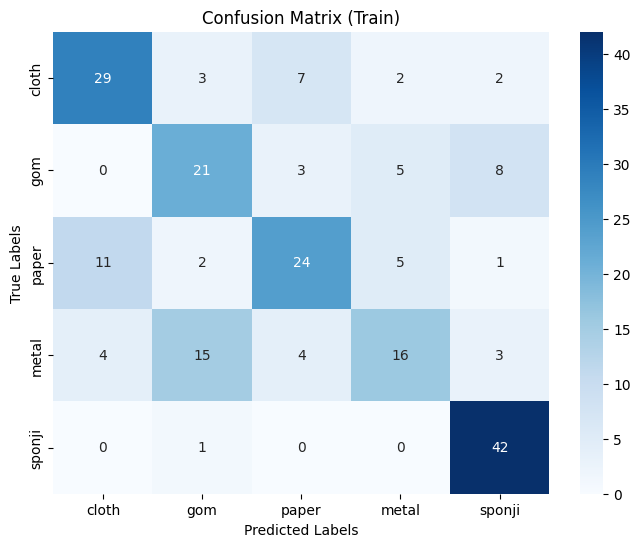

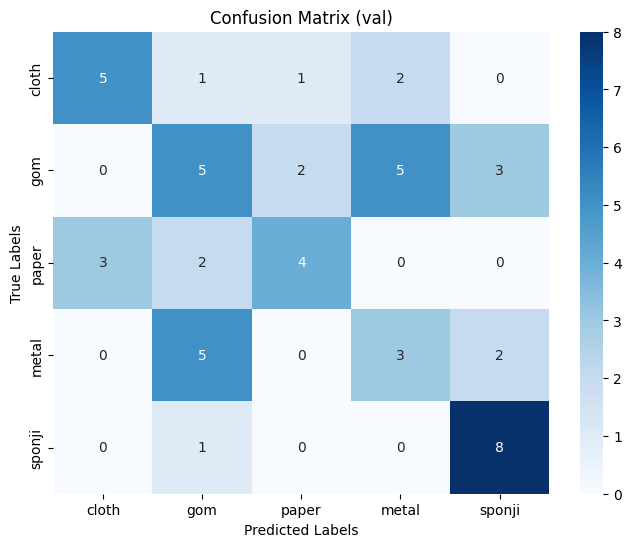

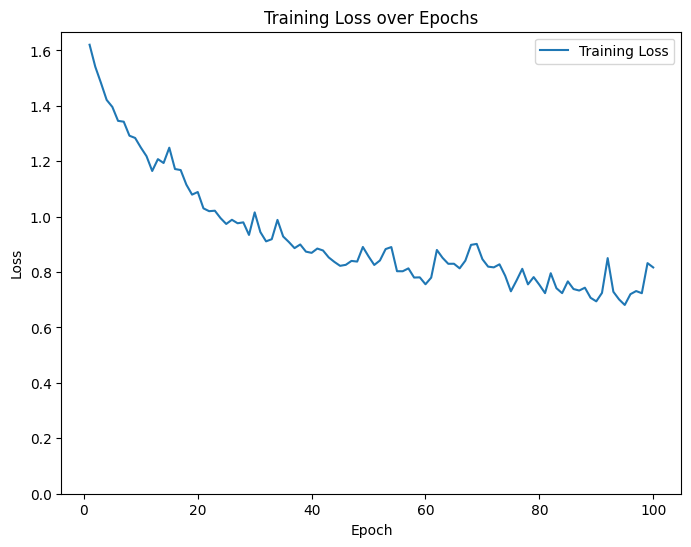

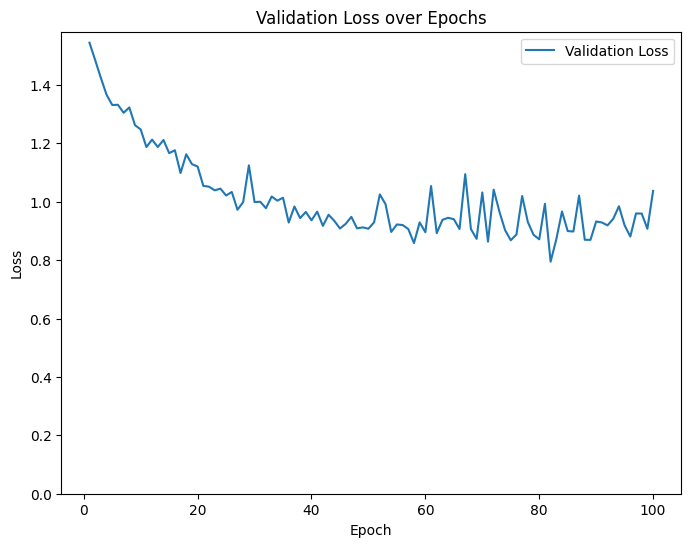

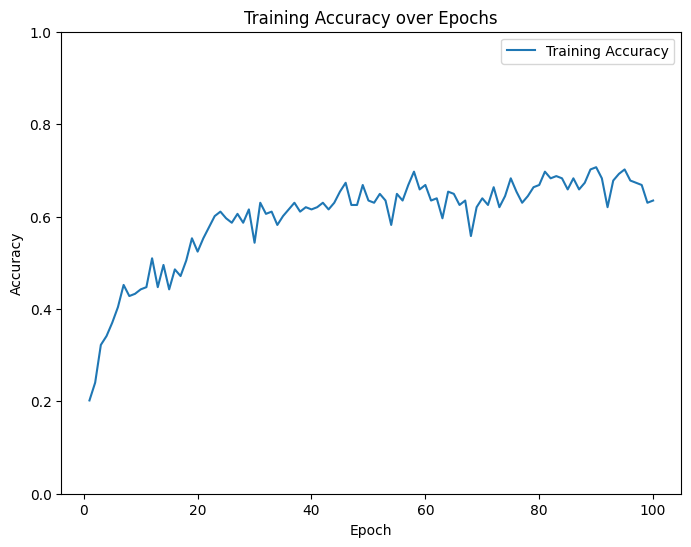

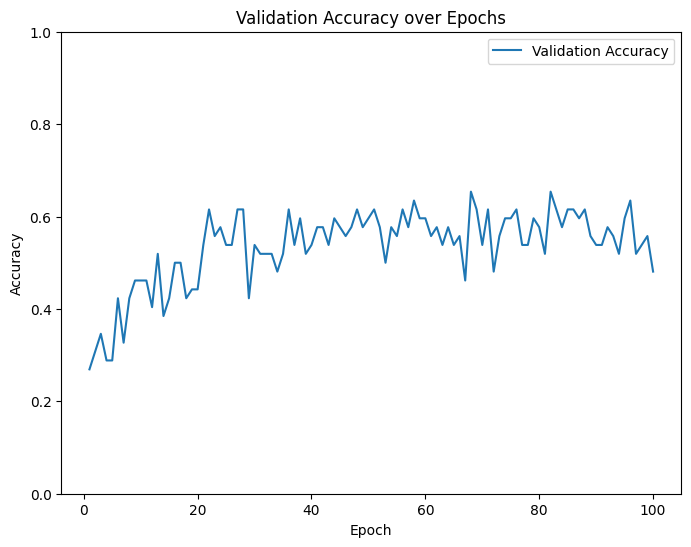

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 混同行列を計算
cm = confusion_matrix(val_labels, val_outputs)

# 訓練データに対する混同行列
cm_train = confusion_matrix(train_labels, train_outputs)

# マッピングから逆引き用リストを作成
labels = [key for key, value in sorted(label_mapping.items(), key=lambda item: item[1])]


# 訓練データの混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Train)')
plt.show()

# 検証データの混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (val)')
plt.show()

# 訓練損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.ylim(0.0)  # y軸の下限を0.0に設定
plt.legend()
plt.show()

# 検証損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.ylim(0.0)  # y軸の下限を0.0に設定
plt.legend()
plt.show()

# 訓練精度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.ylim(0, 1)  # y軸を50-100に設定
plt.legend()
plt.show()

# 検証精度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.ylim(0, 1)  # y軸を50-100に設定
plt.legend()
plt.show()
